# BERT Model for NLP Breast Cancer Dataset


Adapted from original code by Sinan Ozdemir:

https://github.com/sinanuozdemir/oreilly-transformers-video-series/blob/main/notebooks/6%20Hands_on_BERT.ipynb

In [ ]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast, \
     DataCollatorWithPadding, pipeline
!pip install datasets
!pip install accelerate
from datasets import load_metric, Dataset, DatasetDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
!pip install shap
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('drive/MyDrive/June/Supplementary2_V2_preprocessed.xlsx')
# Overview of columns in dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10045 entries, 0 to 10044
Data columns (total 20 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   DB_ID                                              10045 non-null  object 
 1   DISEASE                                            10042 non-null  object 
 2   DIS_CLASS                                          10045 non-null  object 
 3   GENE                                               10045 non-null  object 
 4   PUBMED.ID                                          10045 non-null  int64  
 5   LACKASSO                                           10045 non-null  object 
 6   TITLE                                              2676 non-null   object 
 7   YEAR                                               10045 non-null  int64  
 8   CONCLUSION                                         8502 non-null   object 
 9   REF_SE

## Split dataset into train and test sets

In [ ]:
# X and Y columns (note that we are using the raw text as opposed to the preprocessed version for LR and XGBoost)
data[['REF_SENTENCE_GENE', 'ASSOCIATION_CLASS']]

,REF_SENTENCE_GENE,ASSOCIATION_CLASS
0,No differences in the patterns of L-myc RFLP w...,N
1,CYP1A1 is a gene of the cytochrome P-450 famil...,A
2,"However, mutational analysis of E-cadherin in ...",A
3,The findings provide no evidence for a role of...,N
4,The findings provide no evidence for a role of...,N
...,...,...
10040,The purpose of this study was to determine whe...,X
10041,"In this study, SIPA1 545 C > T polymorphism wa...",X
10042,We found that SIPA1 545 C > T polymorphism was...,Y
10043,Our findings indicate that metastatic breast c...,X


In [ ]:
unique_sequence_labels = sorted(list(set(data['ASSOCIATION_CLASS'])))
print(unique_sequence_labels)
data['label'] = [unique_sequence_labels.index(l) for l in data['ASSOCIATION_CLASS']]
data['label']

['A', 'N', 'X', 'Y']


0        1
1        0
2        0
3        1
4        1
        ..
10040    2
10041    2
10042    3
10043    2
10044    2
Name: label, Length: 10045, dtype: int64

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
train_data = Dataset.from_pandas(X_train)
test_data = Dataset.from_pandas(X_test)
dataset = DatasetDict()
dataset['train'] = train_data
dataset['test'] = test_data

In [ ]:
len(dataset['train']['REF_SENTENCE_GENE']), len(dataset['test']['REF_SENTENCE_GENE'])

(8036, 2009)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return tokenizer(examples["REF_SENTENCE_GENE"], truncation=True)

In [ ]:
seq_clf_tokenized = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/8036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

In [ ]:
for key in ['REF_SENTENCE_GENE', 'ASSOCIATION_CLASS', 'label', 'input_ids', 'attention_mask']:
  print(key + ':', seq_clf_tokenized['train'][0][key])

REF_SENTENCE_GENE: The authors analyzed excision repair cross-complementation group 5/xeroderma pigmentosum group G (ERCC5/XPG) (NER), excision repair cross-complementation group 1 (ERCC1) (NER), and breast cancer 1 (BRCA1) (HR) SNPs and messenger RNA expression levels in tumor specimens from 113 patients with advanced STS who were enrolled in previously published phase 2 trials or in a compassionate-use program. excision repair cross-complementation group 1
ASSOCIATION_CLASS: X
label: 2
input_ids: [101, 1109, 5752, 17689, 4252, 16073, 6949, 2771, 118, 14348, 1891, 1372, 126, 120, 193, 10771, 2692, 1918, 13407, 26173, 6385, 1306, 1372, 144, 113, 23580, 12096, 1571, 120, 161, 2101, 2349, 114, 113, 26546, 2069, 114, 117, 4252, 16073, 6949, 2771, 118, 14348, 1891, 1372, 122, 113, 23580, 12096, 1475, 114, 113, 26546, 2069, 114, 117, 1105, 7209, 4182, 122, 113, 26660, 11356, 1475, 114, 113, 145, 2069, 114, 156, 14576, 1116, 1105, 17957, 13254, 2838, 3001, 1107, 14601, 9985, 1121, 12206, 442

In [ ]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the
#  length of the longest element in the batch, making them all the same length.
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Data Collator will pad data so that all examples are the same input length.
#  Attention mask is how we ignore attention scores for padding tokens

In [ ]:
sequence_clf_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=len(unique_sequence_labels),
)

# set an index -> label dictionary
sequence_clf_model.config.id2label = {i: l for i, l in enumerate(unique_sequence_labels)}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sequence_clf_model.config.id2label[0]

'A'

In [ ]:
metric = load_metric("f1")

def compute_metrics(eval_pred):  # custom method to take in logits and calculate accuracy of the eval set
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='macro')


<ipython-input-15-a8a1a95fe179>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


In [ ]:
epochs = 4

training_args = TrainingArguments(
    output_dir="drive/MyDrive/June/bert_results",
    num_train_epochs=epochs,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,

    # some deep learning parameters that the Trainer is able to take in
    warmup_steps=len(seq_clf_tokenized['train']) // 5,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,

    logging_steps=1,
    log_level='info',
    evaluation_strategy='epoch',
    eval_steps=50,
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=seq_clf_tokenized['train'],
    eval_dataset=seq_clf_tokenized['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [ ]:
# Get initial metrics
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID. If GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this mes

{'eval_loss': 1.358479380607605,
 'eval_f1': 0.1758665170432727,
 'eval_runtime': 13.6791,
 'eval_samples_per_second': 146.866,
 'eval_steps_per_second': 2.339}

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID. If GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this messa

Epoch,Training Loss,Validation Loss,F1
1,1.249700,1.104056,0.186097
2,0.821400,0.683399,0.688280
3,0.708000,0.502230,0.804746
4,0.498500,0.453784,0.827377


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID. If GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this mes

Saving model checkpoint to drive/MyDrive/June/bert_results/checkpoint-126
Configuration saved in drive/MyDrive/June/bert_results/checkpoint-126/config.json
Model weights saved in drive/MyDrive/June/bert_results/checkpoint-126/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID. If GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_no

TrainOutput(global_step=504, training_loss=0.8001457881773748, metrics={'train_runtime': 655.5973, 'train_samples_per_second': 49.03, 'train_steps_per_second': 0.769, 'total_flos': 1921487451031680.0, 'train_loss': 0.8001457881773748, 'epoch': 4.0})

In [ ]:
predictions, label_ids, metrics = trainer.predict(seq_clf_tokenized['test'])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID. If GENE_NEW, __index_level_0__, PUBMED.ID, REF_SENTENCE, REF_SENTENCE_GENE_nopunct, ASSOCIATION_CLASS, DISEASE, LACKASSO, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop_stem, REF_GENE, TITLE, CONCLUSION, WEIGHT, REF_SENTENCE_GENE_nopunct_nonum, YEAR, REF_SENTENCE_GENE_nopunct_nonum_lower_nostop, REF_SENTENCE_GENE_nopunct_nonum_lower, REF_SENTENCE_GENE, GENE, DIS_CLASS, DB_ID are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


In [ ]:
predictions

array([[-1.0711724 , -1.1533787 , -0.702635  ,  3.146478  ],
       [ 2.1395905 , -2.3112214 , -0.10130703,  0.553426  ],
       [-1.427186  , -2.1574073 ,  3.6862798 ,  0.31583843],
       ...,
       [-0.37847334, -1.658917  , -0.7929816 ,  2.9771757 ],
       [-0.9925979 , -1.0268346 , -0.75772804,  3.0480297 ],
       [-0.9286147 , -1.6943517 , -0.450737  ,  3.1194434 ]],
      dtype=float32)

In [ ]:
y_pred_test = np.array([sequence_clf_model.config.id2label[p] for p in np.argmax(predictions, axis=1)])
y_pred_test

array(['Y', 'A', 'X', ..., 'Y', 'Y', 'Y'], dtype='<U1')

In [ ]:
trainer.save_model()

Saving model checkpoint to drive/MyDrive/June/bert_results
Configuration saved in drive/MyDrive/June/bert_results/config.json
Model weights saved in drive/MyDrive/June/bert_results/pytorch_model.bin


## Performance evaluation

In [ ]:
# Load best model
pipe = pipeline("text-classification", "drive/MyDrive/June/bert_results", tokenizer=tokenizer)
results = pipe(list(X_test['REF_SENTENCE_GENE'].values))

In [ ]:
y_train = X_train['ASSOCIATION_CLASS']
y_test = X_test['ASSOCIATION_CLASS']
print('Distribution of true labels:')
print('Training set:')
print(y_train.value_counts())
print('Test set:')
print(y_test.value_counts())

Distribution of true labels:
Training set:
X    3915
Y    2017
A    1292
N     812
Name: ASSOCIATION_CLASS, dtype: int64
Test set:
X    985
Y    490
A    328
N    206
Name: ASSOCIATION_CLASS, dtype: int64


### Get predictions and probabilities

In [ ]:
print('Test set:')
y_pred_proba_test = np.array([dictionary['score'] for dictionary in results])
print(y_pred_proba_test)
y_pred_test = np.array([dictionary['label'] for dictionary in results])
X_test['prediction'] = y_pred_test
X_test['predicted_probability'] = y_pred_proba_test
print(y_pred_test)

Test set:
[0.95274174 0.756006   0.95850819 ... 0.93665349 0.94623202 0.94901508]
['Y' 'A' 'X' ... 'Y' 'Y' 'Y']


### Show metrics

In [ ]:
print('\nTest set:')
display(pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)).T)


Test set:


,precision,recall,f1-score,support
A,0.832215,0.756098,0.792332,328.000000
N,0.794521,0.844660,0.818824,206.000000
X,0.904564,0.885279,0.894818,985.000000
Y,0.774621,0.834694,0.803536,490.000000
accuracy,0.847685,0.847685,0.847685,0.847685
macro avg,0.826480,0.830183,0.827377,2009.000000
weighted avg,0.849775,0.847685,0.848029,2009.000000


### Confusion matrix

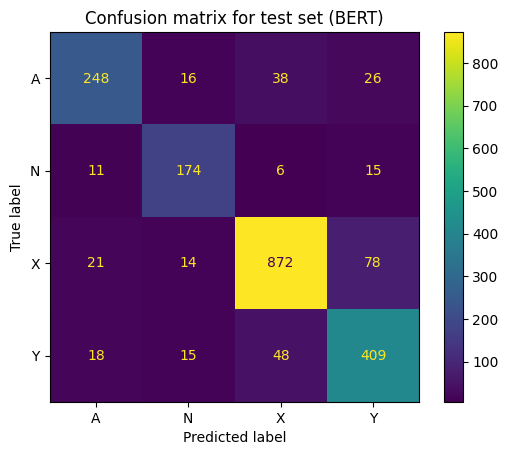

In [ ]:
# For test set
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=sorted(set(y_test))).plot()
plt.title('Confusion matrix for test set (BERT)')
plt.show()

## Hypothesis evaluation

### Question 1: Gene classification

In [ ]:
# Count association classes for every gene
gene_class_counts = data.groupby(['REF_GENE'])['ASSOCIATION_CLASS'].value_counts().unstack()
# Get the primary class without the no-info class since it's the most frequent one
primary_class = gene_class_counts.drop('X', axis=1).idxmax(axis=1)

In [ ]:
pd.set_option('display.max_colwidth', None)
# Number of positive genes in test set
#print(len(set(X_test[y_test == 'Y']['REF_GENE'])), 'positive genes in test set')
# Genes with a primary positive association
positive_genes = gene_class_counts[primary_class == 'Y'].index
# Number of PRIMARY positive instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'Y'].index) & X_test['REF_GENE'].isin(positive_genes)]['REF_GENE']), 'PRIMARY positive instances in test set')
# Correctly predicted positive genes
correct_Y = X_test.loc[y_test[(y_pred_test == 'Y') & (y_test == 'Y')].index]
# PRIMARY positive instances in test set that were correctly predicted
correct_Y_primary = correct_Y[correct_Y['REF_GENE'].isin(positive_genes)]
print(len(correct_Y_primary), 'PRIMARY positive instances in test set that were correctly predicted\n')
print(correct_Y_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_Y_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_Y_primary['WEIGHT']))
correct_Y_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

398 PRIMARY positive instances in test set
330 PRIMARY positive instances in test set that were correctly predicted

BRCA1     19
BRCA2     16
GSTM1     11
FGFR2     11
TP53       9
          ..
NPAS2      1
LOX        1
ERBB2      1
TACC2      1
CLDN10     1
Name: REF_GENE, Length: 162, dtype: int64
Average predicted probability: 0.8774756501118343
Average asssociation weight: 0.6795970778121212


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
7403,"This meta-analysis suggested that TERT rs2736109, rs2853669, rs2736098, and rs10069690 polymorphisms were associated with increased risk of developing breast cancer.",TERT,TERT,0.955399,0.666667
8698,"Here we show that BRCA1 and BRCA2 variants are significantly associated with high breast cancer risk (BRCA1 rs80356932; Genotype T/T OR 8.66, 95% CI 3.16-23.71, p < 0.0001; Allele-T, OR 2.48, 95% CI 1.62-3.81, p < 0.0001 and BRCA2 rs80359182; Genotype C/C OR 4.32, 95% CI 1.95-9.53, p = 0.0001; Allele-C, OR 2.19, 95% CI 1.43-3.34, p = 0.0002).",BRCA1,BRCA1,0.955155,0.484536
4830,The present study shows that the ERCC1 rs11615 and XPF rs6498486 polymorphisms are associated with breast cancer risk in a Chinese population.,ERCC1,ERCC1,0.954488,0.894737
5312,Our findings demonstrated that the hsa-mir-499 rs3746444 polymorphism is associated with higher risk of developing breast cancer in our population.,hsa-mir-499,MIR499A,0.954359,1.000000
4373,"Polymorphisms of -12669 G>A and -7673C>T in the APOB gene were significantly associated with an increased risk of breast cancer (P = 0.000), especially for postmenopausal women (P = 0.000, 0.023).",APOB,APOB,0.953464,1.000000
...,...,...,...,...,...
5466,"In breast cancer, the TP53 gene is frequently mutated and the mutations have been associated with poor prognosis.",TP53,TP53,0.525261,0.512821
9743,"These findings suggest that the APOE ������������4 genotype plays a major role in the prediction of breast cancer, but the PPARA F24 mutation enhances this outcome.",APOE,APOE,0.500240,0.444444
1034,Our study suggests that Chinese women with a family history of breast cancer whose tumors are diagnosed before age of 40 would be a suitable candidate for BRCA1 testing; and BRCA1 tumors in Chinese women exhibit an aggressive phenotype.,BRCA1,BRCA1,0.465889,0.484536
708,"Previous studies indicated that certain p53 polymorphisms confer an increased risk of breast cancer [odds ratios (ORs) and 95% confidence intervals (CIs) = 2.9, 1.4-6.3 Carcinogenesis (Lond.), 17: 1313, 1996; 2.5, 1.3-4.8 Cancer Epidemiol... Whereas multivariate analysis suggested associations between breast cancer and inheritance of Waf-1(ser31) in African-Americans (OR, 2.32; 95% CI = 0.66-5.60; n = 37 cases and 65 controls) and Latinas (OR, 2.22; 95% CI = 0.71-6.89; n = 30 cases and 75 controls), and inheritance of p53(1-2-1) in Caucasians (OR, 3.15; 95% CI = 1.14-8.89; n = 93 cases and 187 controls), we did not see an interaction between Waf-1(ser31) and p53(1-2-1). Consistent with the finding that p53(1-2-1) is a risk factor for Caucasian women was the observation of a strong interaction between race and p53 (P < 0.01).",p53,TP53,0.465667,0.512821


In [ ]:
incorrect_Y = X_test.loc[y_test[(y_pred_test != 'Y') & (y_test == 'Y')].index]
# PRIMARY positive instances in test set that were incorrectly predicted
incorrect_Y_primary = incorrect_Y[incorrect_Y['REF_GENE'].isin(positive_genes)]
print(len(incorrect_Y_primary), 'PRIMARY positive instances in test set that were incorrectly predicted\n')
print(incorrect_Y_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_Y_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_Y_primary['WEIGHT']))
incorrect_Y_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

68 PRIMARY positive instances in test set that were incorrectly predicted

BRCA2                12
BRCA1                10
MTHFR                 4
VDR                   3
FGFR2                 3
GSTT1                 2
CHEK2                 2
TP53                  2
FANCM                 2
p53                   2
estrogen receptor     1
UGT2B17               1
TNRC9                 1
ESR1                  1
IL6                   1
ODC                   1
TCF7L2                1
ANKLE1                1
BRCA2-Met1915Thr      1
MSH2                  1
APOBEC3B              1
TLR2                  1
CLCA2                 1
FGF10                 1
ATM                   1
NCoA3                 1
MICA                  1
GSTP1                 1
SIPA1                 1
PIK3CA                1
c-erbB-2              1
XRCC4                 1
RCCD1                 1
GSTTI                 1
HLA-DRB 1*12          1
CYP2D6*4              1
Name: REF_GENE, dtype: int64
Average predicted probability: 0

,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
4938,Four studies on SIPA1 and breast cancer were included in our meta-analysis.,SIPA1,SIPA1,X,0.979663,0.666667
6369,Numerous studies have evaluated the association between TCF7L2 gene polymorphisms (rs12255372 and rs7903146) and breast cancer risk.,TCF7L2,TCF7L2,X,0.973329,0.818182
7949,A total of 35 studies which examined the association of MTHFR A1298C polymorphism with breast cancer and/or ovarian cancer were identified.,MTHFR,MTHFR,X,0.972942,0.508333
2709,Approximately 10% of Ashkenazi Jewish (AJ) women with breast cancer (BC) carry a founder mutation in BRCA1 or BRCA2.,BRCA1,BRCA1,X,0.972058,0.484536
5247,We investigated whether TNRC9 polymorphisms are associated with risk of breast cancer in Chinese women of the Han nationality.,TNRC9,TOX3,X,0.970943,0.680000
...,...,...,...,...,...,...
2664,"The p53 R72P polymorphism has been suggested to play a role in many cancers, including breast cancer... These results suggest no effect of either R72P allele on breast cancer risk but a significantly reduced survival for 72P homozygous breast cancer patients.",p53,TP53,N,0.492441,0.512821
624,Although patients with BRCA2 germline mutations did not have a distinct histological phenotype they had an improved overall survival (100% vs 65%). Our findings suggest that there is a cluster of novel mutations in exons 10 and 11 in Greek patients with familial breast cancer.,BRCA2,BRCA2,A,0.470376,0.496667
6196,"Conclusively, our findings suggest that GSTT1 null genotype and SULT1A1 G638A AA genotype could be uselful genetic markers for breast cancer prognosis.",GSTT1,GSTT1,X,0.466465,0.672131
7868,"While genome-wide association studies (GWAS) have implicated RCCD1 and ANKLE1 in breast cancer risk, they have not identified the remaining three genes.",ANKLE1,ANKLE1,N,0.417865,1.000000


In [ ]:
# Number of negative genes in test set
#print(len(set(X_test[y_test == 'N']['REF_GENE'])), 'negative genes in test set')
# Genes with a primary negative association
negative_genes = gene_class_counts[primary_class == 'N'].index
# Number of PRIMARY negative instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'N'].index) & X_test['REF_GENE'].isin(negative_genes)]['REF_GENE']), 'PRIMARY negative instances in test set')
# Correctly predicted negative genes
correct_N = X_test.loc[y_test[(y_pred_test == 'N') & (y_test == 'N')].index]
# PRIMARY negative instances in test set that were correctly predicted
correct_N_primary = correct_N[correct_N['REF_GENE'].isin(negative_genes)]
print(len(correct_N_primary), 'PRIMARY negative instances in test set that were correctly predicted\n')
print(correct_N_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_N_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_N_primary['WEIGHT']))
correct_N_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

79 PRIMARY negative instances in test set
65 PRIMARY negative instances in test set that were correctly predicted

BRIP1                                       2
MTRR                                        2
TGFBR1*6A                                   2
TLR                                         2
SSTR1-SSTR5                                 2
LEP                                         2
IGHMBP2                                     1
GSTO1                                       1
p53--G13964C                                1
RAD51L1                                     1
SOD2                                        1
ABCB11                                      1
IL-6 -174                                   1
GEN1                                        1
ITGAv                                       1
ITGB3                                       1
CRAC1                                       1
BUB3                                        1
GPX1                                        1
DNMT-3B    

,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
1963,"In conclusion, this meta-analysis strongly suggests that MTRR A66G polymorphism is not associated with breast cancer risk, especially in Caucasians and Asians.",MTRR,MTRR,0.945377,0.625000
1795,"Conclusively, this meta-analysis strongly suggests that SOD2 Val16Ala polymorphism is not associated with breast cancer susceptibility.",SOD2,SOD2,0.944740,0.352941
1413,"In conclusion, our study shows that there is no association between TGFBR1*6A and breast cancer risk.",TGFBR1*6A,TGFBR1,0.942314,0.666667
2215,"We observed no association between AIB1 genotype and breast cancer incidence, or specific tumor characteristics.",AIB1,NCOA3,0.940763,0.571429
3015,No association for allele and genotype frequencies of the 538G>A variant in ABCB11 with breast cancer risk was found.,ABCB11,ABCB11,0.940290,1.000000
...,...,...,...,...,...
6149,Our data suggest that pathogenic mutations in KLLN are rare in breast cancer families and the c.339_340delAG variant does not represent a high-penetrance breast cancer risk allele.,KLLN,KLLN,0.727322,1.000000
14,"Although polymorphisms within the IL1 gene cluster do not seem to influence breast cancer risk or phenotype, presence of the -174C IL6 allele increases the risk of breast cancer in Caucasian women in a dose-dependent fashion.",IL1,IL1A,0.703605,0.500000
2515,"Overall there was no association between breast cancer and NOD2 (OR = 1.1; p = 0.76), but significant associations were observed between the presence of the allele and early-onset breast cancer (OR = 1.9; p = 0.01) and between the allele and ductal breast cancer with an in situ component (OR = 2.2; p = 0.006).",NOD2,NOD2,0.690764,1.000000
567,It is unlikely that common variants in BRIP1 contribute significantly to breast cancer susceptibility.,BRIP1,BRIP1,0.526103,0.272727


In [ ]:
incorrect_N = X_test.loc[y_test[(y_pred_test != 'N') & (y_test == 'N')].index]
# PRIMARY negative instances in test set that were incorrectly predicted
incorrect_N_primary = incorrect_N[incorrect_N['REF_GENE'].isin(negative_genes)]
print(len(incorrect_N_primary), 'PRIMARY negative instances in test set that were incorrectly predicted\n')
print(incorrect_N_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_N_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_N_primary['WEIGHT']))
incorrect_N_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

14 PRIMARY negative instances in test set that were incorrectly predicted

ITGB3          1
GNB3 825C      1
IL-18          1
GSTO1          1
MMP3 5A/6A     1
IRS1           1
MTHFR C677T    1
L-myc          1
CYP17 MspA1    1
APEX           1
PPARG          1
RAD51L1        1
CYP1A2         1
GH1            1
Name: REF_GENE, dtype: int64
Average predicted probability: 0.7178645155259541
Average asssociation weight: 0.4659789742142858


,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
872,Our results suggest that CYP17 MspA1 polymorphism may be at best a weak modifier of breast cancer risk but is not a significant independent risk factor.,CYP17 MspA1,CYP17A1,A,0.928037,0.245283
5885,This meta-analysis demonstrates that GSTO2 polymorphism may significantly increase cancer risk in Caucasian population and is associated with elevated risk of breast cancer; while GSTO1 polymorphism is not associated with cancer risk.,GSTO1,GSTO1,A,0.900570,0.666667
8603,"We found no significant differences between breast cancer patients and control subjects regarding IL-18 rs1946518 polymorphism (������������2=1.78, p=0.411).",IL-18,IL18,X,0.891087,0.400000
487,"The results revealed that the ITGB3_Leu33Pro polymorphism was associated with a 2.5-fold increased risk of ovarian cancer, whereas no association with breast cancer risk was found.",ITGB3,ITGB3,Y,0.854915,0.666667
0,No differences in the patterns of L-myc RFLP were found between breast cancer patients and healthy individuals.,L-myc,MYCL,X,0.803412,1.000000
5298,"Consistent with their breast cancer associations, the C-allele of rs3817198 in LSP1 was positively associated with both adjusted dense area (P = 0.00005) and adjusted percent density (P = 0.001), whereas the A-allele of rs10483813 in RAD51L1 was inversely associated with adjusted percent density (P = 0.003), but not with adjusted dense area (P = 0.07).",RAD51L1,RAD51B,Y,0.738926,0.250000
2348,"No associations with breast cancer were observed for: APEX Q51H; XRCC1 R280H; IGFPB3 -202A>C; TGFss1 L10P, P25R, and T263I; BRCA2 N289H and T1915M; BRIP1 -64A>C; and ZNF350 (or ZBRK1) 1845C>T, L66P, R501S, and S472P... Some variants in genes within the base-excision repair pathway (XRCC1) and BRCA1 interacting proteins (BRIP1) may play a role as low penetrance breast cancer risk alleles. Previous association studies of breast cancer and BRCA2 N372H and functional observations for APEX D148E ran counter to our findings of decreased risks.",APEX,APEX1,A,0.720893,0.375000
2375,The MMP3 5A/6A promoter polymorphism does not appear to influence breast cancer susceptibility but may be linked to a higher risk for metastasizing among breast cancer patients.,MMP3 5A/6A,MMP3,A,0.703600,0.285714
2564,"The aim of this study was to explore a possible association between p53 codon 72, Her 2 codon 655 and MTHFR C677T polymorphisms and breast cancer in Northern Greece... A total of 42 women with breast cancer as well as healthy controls were investigated and results showed that p53 codon 72 polymorphism is statistically significantly associated with breast cancer (OR for Arg/Arg to non-Arg/Arg was 6.66, P = 0.0001 at 95% CI 2.63-16.9), but not Her 2 and MTHFR polymorphisms are associated with breast cancer (OR for Ile/Ile to non-Ile/Ile was 1.33, P = 0.54 at 95% CI 0.52-3.38 and OR for T/T versus non-T/T was 1.07, P = 0.89 at 95% CI 0.35-3.25).",MTHFR C677T,MTHFR,Y,0.648135,0.250000
617,"No apparent association was found for any of the other six single nucleotide polymorphisms evaluated in the AhR, CYP1A1, CYP1A2, and CYP1B1 genes... Results from this study suggest that rs4680 in the COMT gene and rs4646903 in the CYP1A1 gene may be genetic markers for breast cancer prognosis in Chinese women.",CYP1A2,CYP1A1,A,0.632855,0.234375


In [ ]:
# Genes with a primary ambiguous association
ambiguous_genes = gene_class_counts[primary_class == 'A'].index
# Number of PRIMARY ambiguous instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'A'].index) & X_test['REF_GENE'].isin(ambiguous_genes)]['REF_GENE']), 'PRIMARY ambiguous instances in test set')
# Correctly predicted ambiguous genes
correct_A = X_test.loc[y_test[(y_pred_test == 'A') & (y_test == 'A')].index]
# PRIMARY ambiguous instances in test set that were correctly predicted
correct_A_primary = correct_A[correct_A['REF_GENE'].isin(ambiguous_genes)]
print(len(correct_A_primary), 'PRIMARY ambiguous instances in test set that were correctly predicted\n')
print(correct_A_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_A_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_A_primary['WEIGHT']))
correct_A_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

202 PRIMARY ambiguous instances in test set
152 PRIMARY ambiguous instances in test set that were correctly predicted

CYP1A1                               5
RAD51                                5
BRCA1/2                              5
XPD                                  4
XRCC1                                4
                                    ..
PAI-1                                1
GLO1                                 1
USP1                                 1
cyclin-dependent kinase inhibitor    1
CYP1A2*1F                            1
Name: REF_GENE, Length: 112, dtype: int64
Average predicted probability: 0.8218643579043841
Average asssociation weight: 0.5813599992171052


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
1470,"We investigated 60 polymorphisms in the TUBD1, SEPT4, PRKCA, TBX2, TBX4, TEX14, TLK2, YPEL2, and PPM1E genes from this amplicon for association with breast cancer risk among 798 Caucasian breast cancer cases and 843 unaffected Caucasian controls from the Mayo Clinic... These findings suggest that single polymorphisms and combinations of polymorphisms within candidate oncogenes from the 17q23 amplicon may influence risk of breast cancer overall and possibly specific molecular subtypes of breast tumors.",TEX14,TEX14,0.943170,1.000000
1112,"we examined the association between breast cancer risk and 18 non-synonymous single-nucleotide polymorphisms (nsSNPs) in four DNA repair pathways-(i) base excision repair: ADPRT V762A, APE1 D148E, XRCC1 R194W/R280H/R399Q and POLD1 R119H; (ii) nucleotide excision repair: ERCC2 D312N/K751Q, ERCC4 R415Q, ERCC5 D1104H and XPC A499V/K939Q; (iii) mismatch repair: MLH1 I219V, MSH3 R940Q/T1036A and MSH6 G39E and (iv) double-strand break repair: NBS1 E185Q and XRCC3 T241M... Our results suggest that combined nsSNPs in multiple DNA repair pathways may contribute to breast cancer risk and larger studies are warranted to further evaluate polygenic models of DNA repair in breast cancer risk.",APE1,APEX1,0.942824,0.250000
1111,"we examined the association between breast cancer risk and 18 non-synonymous single-nucleotide polymorphisms (nsSNPs) in four DNA repair pathways-(i) base excision repair: ADPRT V762A, APE1 D148E, XRCC1 R194W/R280H/R399Q and POLD1 R119H; (ii) nucleotide excision repair: ERCC2 D312N/K751Q, ERCC4 R415Q, ERCC5 D1104H and XPC A499V/K939Q; (iii) mismatch repair: MLH1 I219V, MSH3 R940Q/T1036A and MSH6 G39E and (iv) double-strand break repair: NBS1 E185Q and XRCC3 T241M... Our results suggest that combined nsSNPs in multiple DNA repair pathways may contribute to breast cancer risk and larger studies are warranted to further evaluate polygenic models of DNA repair in breast cancer risk.",MLH1,MLH1,0.942738,0.400000
1121,"we examined the association between breast cancer risk and 18 non-synonymous single-nucleotide polymorphisms (nsSNPs) in four DNA repair pathways-(i) base excision repair: ADPRT V762A, APE1 D148E, XRCC1 R194W/R280H/R399Q and POLD1 R119H; (ii) nucleotide excision repair: ERCC2 D312N/K751Q, ERCC4 R415Q, ERCC5 D1104H and XPC A499V/K939Q; (iii) mismatch repair: MLH1 I219V, MSH3 R940Q/T1036A and MSH6 G39E and (iv) double-strand break repair: NBS1 E185Q and XRCC3 T241M... Our results suggest that combined nsSNPs in multiple DNA repair pathways may contribute to breast cancer risk and larger studies are warranted to further evaluate polygenic models of DNA repair in breast cancer risk.",XPC,XPC,0.942588,0.538462
1109,"we examined the association between breast cancer risk and 18 non-synonymous single-nucleotide polymorphisms (nsSNPs) in four DNA repair pathways-(i) base excision repair: ADPRT V762A, APE1 D148E, XRCC1 R194W/R280H/R399Q and POLD1 R119H; (ii) nucleotide excision repair: ERCC2 D312N/K751Q, ERCC4 R415Q, ERCC5 D1104H and XPC A499V/K939Q; (iii) mismatch repair: MLH1 I219V, MSH3 R940Q/T1036A and MSH6 G39E and (iv) double-strand break repair: NBS1 E185Q and XRCC3 T241M... Our results suggest that combined nsSNPs in multiple DNA repair pathways may contribute to breast cancer risk and larger studies are warranted to further evaluate polygenic models of DNA repair in breast cancer risk.",MSH6,MSH6,0.942522,0.600000
...,...,...,...,...,...
590,"The DHFR 19-bp deletion polymorphism affects the transcription of DHFR gene in humans. Multivitamin supplements may place a subgroup of women (ie, those with the -19-bp allele) at elevated risk of developing breast cancer.",DHFR,DHFR,0.466706,1.000000
715,"In this study, we investigated whether genetic variation in the JAK2 gene and the STAT gene region (STAT3, STAT5A and STAT5B) is associated with breast cancer (BC) risk... Haplotypes in the JAK2 gene were not associate

In [ ]:
incorrect_A = X_test.loc[y_test[(y_pred_test != 'A') & (y_test == 'A')].index]
# PRIMARY ambiguous instances in test set that were incorrectly predicted
incorrect_A_primary = incorrect_A[incorrect_A['REF_GENE'].isin(ambiguous_genes)]
print(len(incorrect_A_primary), 'PRIMARY ambiguous instances in test set that were incorrectly predicted\n')
print(incorrect_A_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_A_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_A_primary['WEIGHT']))
incorrect_A_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

50 PRIMARY ambiguous instances in test set that were incorrectly predicted

BRCA1/2                     4
AR                          3
RAD51                       2
BRCA1/BRCA2                 2
CYP1A1                      2
KRAS                        2
CYP2D6                      2
XPD                         2
MDR1                        1
FasL                        1
calcium-sensing receptor    1
PHB                         1
EPH                         1
Cytochrome P450 1B1         1
CYB5A                       1
XPCs                        1
COMT                        1
PGC                         1
TGF-_1                      1
IGFBP3                      1
XRCC3                       1
IL-1RN                      1
CDKN2A                      1
CYP1A1*2C                   1
CHEK1                       1
AKT                         1
MDR-1                       1
MPO                         1
HSD17B1                     1
PI3K                        1
p73                     

,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
4476,"We aimed to evaluate whether the hormone receptor expression, HER2 and MYC genes and their protein status, and KRAS codon 12 mutations may be prognostic or predictive biomarkers of breast cancer.",KRAS,KRAS,X,0.984195,0.444444
2680,"Data on the association between the AR repeat length and ovarian cancer, both in general and among carriers of mutations in the breast cancer 1 and 2 (BRCA1/2) genes, are inconclusive.",AR,AKR1B1,X,0.971642,0.714286
2145,"Cumulative distant metastasis-free and overall survival at 6 years in all 42 BRCA1/2 mutation carriers with invasive breast cancer were 83.9% (95% CI, 64.1% to 93.3%) and 92.7% (95% CI, 79.0% to 97.6%), respectively, and 100% in the familial groups (n=43).",BRCA1/2,BRCA2,X,0.968391,0.373333
1180,"In our study, we investigated whether polymorphisms of the HIF-1alpha gene may account for the expression patterns of HIF-1alpha protein and impact of clinical progression in breast cancer.",HIF-1alpha,HIF1A,X,0.961697,0.400000
1156,"MBC appears to be biologically similar to breast cancer in females, however the phenotypic characteristics of BRCA1/2-related MBCs are not yet well elucidated.",BRCA1/2,BRCA1,X,0.953350,0.414948
1155,"MBC appears to be biologically similar to breast cancer in females, however the phenotypic characteristics of BRCA1/2-related MBCs are not yet well elucidated.",BRCA1/2,BRCA2,X,0.953350,0.373333
960,We evaluated the presence of single nucleotide polymorphism (SNP) C3435T of the MDR-1 gene and its correlation with the response to primary chemotherapy using the RECIST criteria. Forty-one Brazilian women with stages II and III breast cancer using the PCR-RFLP analysis were evaluated.,MDR-1,ABCB1,X,0.936687,0.517241
4635,This study analyzed the occurrences of polymorphism (SNP) in the MDR1 gene in breast cancer patients and determined a possible association with chemotherapy.,MDR1,ABCB1,X,0.933125,0.517241
1626,"MPO can be inhibited and/or upregulated by commonly used drugs; thus, our findings merit further investigation for optimization of therapeutics for breast cancer.",MPO,MPO,X,0.918909,0.500000
311,"Our results suggest that AGT plays a role in breast cancer risk in postmenopausal women, whereas the role of AGTR1 needs further studying.",AGTR1,AGTR1,Y,0.916432,0.428571


In [ ]:
# Genes with a primary noinfo association
noinfo_genes = gene_class_counts[primary_class.isna()].index
# Number of PRIMARY noinfo instances in test set
print(len(X_test[X_test.index.isin(y_test[y_test == 'X'].index) & X_test['REF_GENE'].isin(noinfo_genes)]['REF_GENE']), 'PRIMARY no-info instances in test set')
# Correctly predicted noinfo genes
correct_X = X_test.loc[y_test[(y_pred_test == 'X') & (y_test == 'X')].index]
# PRIMARY noinfo instances in test set that were correctly predicted
correct_X_primary = correct_X[correct_X['REF_GENE'].isin(noinfo_genes)]
print(len(correct_X_primary), 'PRIMARY no-info instances in test set that were correctly predicted\n')
print(correct_X_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(correct_X_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(correct_X_primary['WEIGHT']))
correct_X_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

128 PRIMARY no-info instances in test set
109 PRIMARY no-info instances in test set that were correctly predicted

CPB2                      3
ATP6                      2
MRP1                      2
OS                        2
PPP2R2B                   2
                         ..
JAK1                      1
MAF                       1
CSMD1                     1
ankylosing spondylitis    1
bile salt export pump     1
Name: REF_GENE, Length: 101, dtype: int64
Average predicted probability: 0.8924777242568654
Average asssociation weight: 0.0


,REF_SENTENCE,REF_GENE,GENE_NEW,predicted_probability,WEIGHT
3032,"In this study we have analyzed frequencies of genomic variants in FTO, MC4R and NRXN3 in the group of 134 breast cancer patients.",MC4R,X,0.987418,0.0
8864,"To explore correlations between body mass index (BMI), preoperative systemic immune-inflammation index (SII) and endocrine therapy resistance, and evaluate BMI and SII as predictors of resistance, in patients with luminal breast cancer.",SII,X,0.987358,0.0
3034,"In this study we have analyzed frequencies of genomic variants in FTO, MC4R and NRXN3 in the group of 134 breast cancer patients.",NRXN3,X,0.987332,0.0
6901,"In this study, we examined 114 paired samples (tumor and normal tissues) from breast cancer patients to study the genotype distribution and somatic mutation of the SNP in MIR 196A2 (rs11614913 C-T).",MIR,X,0.987257,0.0
3647,"Our aims were to evaluate the effects of polymorphisms in the hepatic drug uptake transporter organic anion transporting polypeptide 1B1 (OATP1B1, SLCO1B1) and efflux transporters multidrug resistance-associated protein 2 (MRP2, ABCC2), bile salt export pump (BSEP, ABCB11), and breast cancer-related protein (BCRP, ABCG2) on single-dose pravastatin pharmacokinetics in healthy European- and African-American participants.",bile salt export pump,X,0.986785,0.0
...,...,...,...,...,...
9520,These findings warrant further studies and suggest that genetic markers in TP53 network genes such as PRKAG2 and PPP2R2B might affect prognosis and treatment outcome in breast cancer patients.,PPP2R2B,X,0.542037,0.0
6475,"Luciferase assays did not identify SNPs that affect transactivation of ZNF365, but identified a protective haplotype in iCHAV2, associated with silencing of the NRBF2 promoter, implicating this gene in the etiology of breast cancer.",NRBF2,X,0.537735,0.0
8937,Clinical background comparison for individuals who underwent RRSO vs. those > 45 years of age who did not undergo RRSO revealed that significant factors were represented by B1 (p < 0.0001); child bearing (p < 0.00001); and breast cancer history (p < 0.01).,B1,X,0.535344,0.0
5493,We confirmed that heightened expression of MCL1 resulted in decreased proliferation ability of breast cancer cells.,MCL1,X,0.503909,0.0


In [ ]:
incorrect_X = X_test.loc[y_test[(y_pred_test != 'X') & (y_test == 'X')].index]
# PRIMARY noinfo instances in test set that were incorrectly predicted
incorrect_X_primary = incorrect_X[incorrect_X['REF_GENE'].isin(noinfo_genes)]
print(len(incorrect_X_primary), 'PRIMARY noinfo instances in test set that were incorrectly predicted\n')
print(incorrect_X_primary['REF_GENE'].value_counts())
print('Average predicted probability:', np.mean(incorrect_X_primary['predicted_probability']))
print('Average asssociation weight:', np.mean(incorrect_X_primary['WEIGHT']))
incorrect_X_primary[['REF_SENTENCE', 'REF_GENE', 'GENE_NEW', 'prediction', 'predicted_probability', 'WEIGHT']].sort_values(by=['predicted_probability', 'WEIGHT'], ascending=False)

19 PRIMARY noinfo instances in test set that were incorrectly predicted

PARP                                                2
RCC                                                 1
IL-21                                               1
STMN1                                               1
CI                                                  1
PLA2G4C                                             1
multidrug resistance-associated protein 4           1
NRG2                                                1
sex hormone binding globulin                        1
LE                                                  1
BCL3                                                1
BNIP3                                               1
HPCAL1                                              1
CPM                                                 1
C6orf48                                             1
HRD                                                 1
TYRP1                                               1
peroxisom

,REF_SENTENCE,REF_GENE,GENE_NEW,prediction,predicted_probability,WEIGHT
8301,"When all the eligible studies were pooled into this meta-analysis, there was no evidence of significant association between breast cancer risk and COMT Val158Met polymorphism in any genetic model (dominant model: odds ratio [OR] = 0.99, 95% confidence interval [CI] = 0.94-1.04, P value of heterogeneity test [P(h)] = 0.009, I(2) = 36.9%; recessive model: OR = 0.97, 95% CI = 0.92-1.02, P(h) = 0.044, I(2) = 28.6%; additive model: OR = 0.98, 95% CI = 0.91-1.05, P(h) = 0.004, I(2) = 40.4%).",CI,X,N,0.940733,0.0
6070,The HRD scores showed strong correlation with BRCA1/2 deficiency regardless of breast cancer subtype.,HRD,X,Y,0.921133,0.0
8962,There are observational data suggesting an inverse association between circulating concentrations of sex hormone binding globulin (SHBG) and risk of postmenopausal breast cancer.,sex hormone binding globulin,X,Y,0.910880,0.0
3315,"Multivariate logistic regression analysis with adjustment for age, body mass index, presence of hyperlipidemia, diabetes mellitus, and current smoking and drinking revealed that one single nucleotide polymorphism (SNP), IMS-JST126186, in HPCAL1 (hippocalcin-like 1) in women and two SNPs, IMS-JST149391 and IMS-JST149390, in GREB1 (gene regulated by estrogen in breast cancer 1) in men were significantly associated with both prevalence of hypertension and blood pressure levels.",HPCAL1,X,Y,0.879155,0.0
9953,"Our present study established a robust association between the functional polymorphism (rs12508721C>T) in IL-21 and prognosis of breast cancer, indicating that this polymorphism may be a potential biomarker for prognosis of breast cancer.",IL-21,X,Y,0.851371,0.0
8069,"High STMN1 expression is a possible marker of breast cancer aggressiveness in association with proliferation, phenotype and cancer stem cell type.",STMN1,X,Y,0.823179,0.0
9764,"In addition, both chr6_31911109 at C6orf48 and chr6_31975605 at ZBTB12, another two of the seven SNPs, show relevance with ER-positive breast cancer.",C6orf48,X,Y,0.817604,0.0
5406,"BMI showed a positive association with the methylation of extracellular superoxide dismutase (r = 0.21, p < 0.05), Ras-association (RalGDS/AF-6) domain family member 1 (RASSF1A) (r = 0.31, p < 0.001), and breast cancer type 1 susceptibility protein (r = 0.19, p < 0.05); and inverse association with methylation of BNIP3 (r = -0.48, p < 0.0001).",BNIP3,X,Y,0.774477,0.0
4843,"Multiple SNPs in FGF1, FGF2, and NRG2 significantly interacted with multiple SNPs in EGFR, ERBB2, FGFR2, and PDGFB, suggesting that breast cancer risk is dependent on the collective effects of genetic variants in other GFs.",NRG2,X,Y,0.754814,0.0
9659,"Serum urea was inversely associated with RCC in females (effect = 1.93; 95% CI: 1.24 to 3.01; p = 0.004) but exhibited null association with RCC in males, breast cancer (BRCA) in both genders and prostate cancer (PCa) in males.",RCC,X,Y,0.714058,0.0


### Question 2: Association explainability

In [ ]:
pipe.model.config.label2id = {'A': 0, 'N': 1, 'X': 2, 'Y': 3}
explainer = shap.Explainer(pipe)

In [ ]:
shap_values = explainer(X_test['REF_SENTENCE_GENE'].iloc[:30])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 1/30 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 3/30 [04:16<20:22, 45.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 4/30 [04:57<18:47, 43.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 5/30 [06:36<26:45, 64.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 6/30 [07:16<22:17, 55.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 7/30 [09:22<30:15, 78.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 8/30 [10:05<24:43, 67.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 9/30 [10:58<21:59, 62.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 10/30 [11:53<20:11, 60.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 11/30 [13:07<20:27, 64.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 12/30 [13:55<17:49, 59.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 13/30 [15:00<17:19, 61.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 14/30 [16:18<17:42, 66.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 15/30 [18:08<19:53, 79.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 16/30 [19:04<16:51, 72.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 17/30 [20:16<15:39, 72.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 18/30 [21:06<13:07, 65.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 19/30 [21:55<11:04, 60.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 20/30 [23:12<10:55, 65.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 21/30 [24:36<10:41, 71.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 22/30 [25:30<08:47, 65.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 23/30 [29:37<14:02, 120.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 24/30 [31:01<10:55, 109.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 25/30 [32:14<08:11, 98.31s/it] 

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 26/30 [32:49<05:17, 79.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 27/30 [35:02<04:46, 95.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 28/30 [35:52<02:43, 82.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 29/30 [36:40<01:11, 71.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 30/30 [37:23<00:00, 63.20s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 31it [40:38, 81.28s/it] 


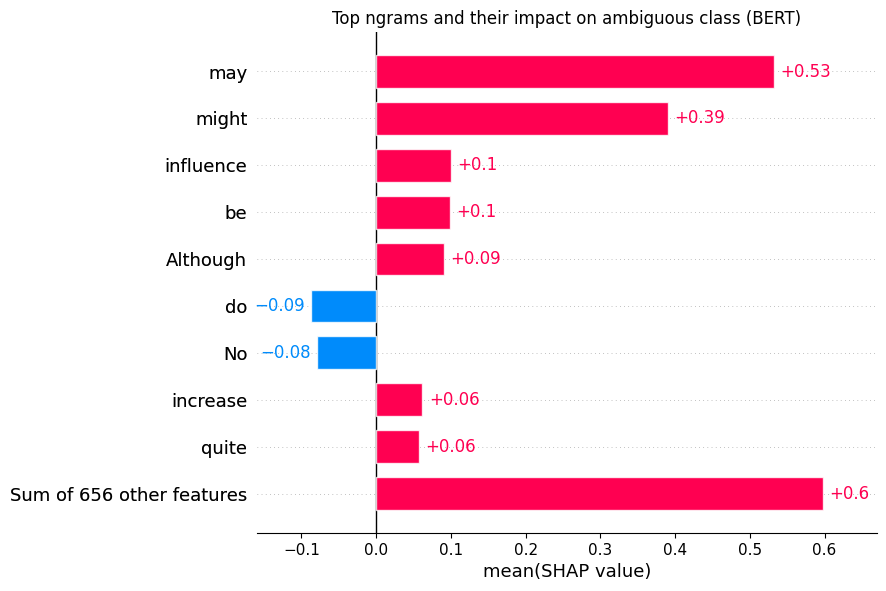

In [ ]:
plt.title('Top ngrams and their impact on ambiguous class (BERT)')
shap.plots.bar(shap_values[:, :, "A"].mean(0))

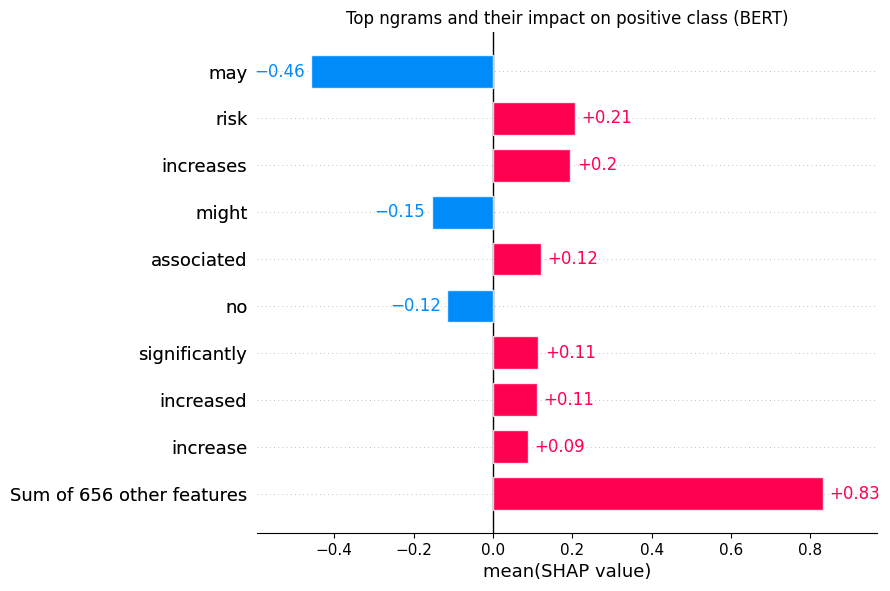

In [ ]:
plt.title('Top ngrams and their impact on positive class (BERT)')
shap.plots.bar(shap_values[:, :, "Y"].mean(0))

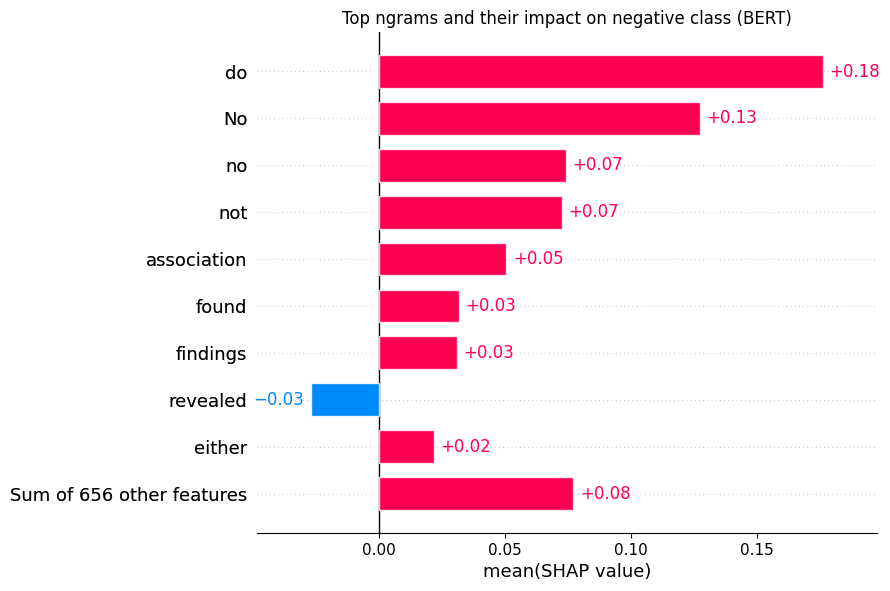

In [ ]:
plt.title('Top ngrams and their impact on negative class (BERT)')
shap.plots.bar(shap_values[:, :, "N"].mean(0))

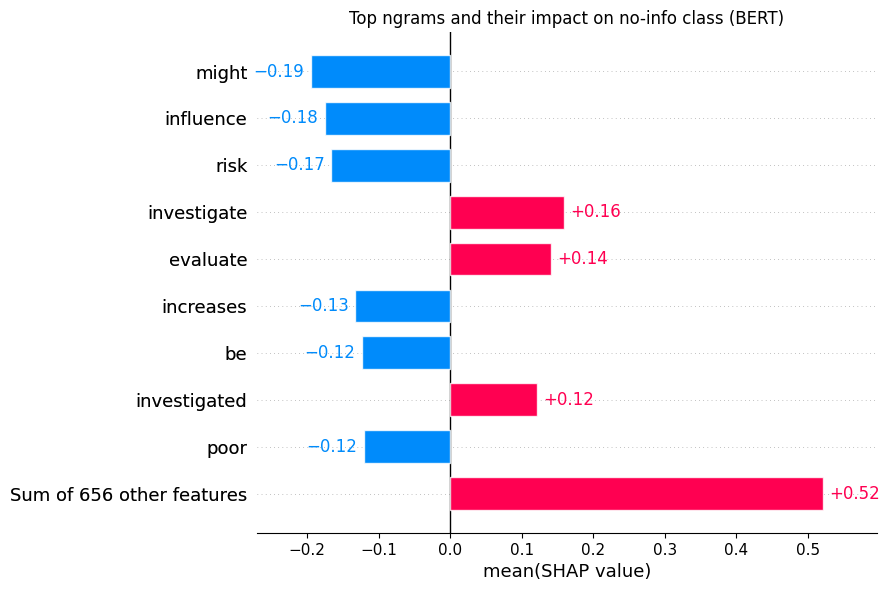

In [ ]:
plt.title('Top ngrams and their impact on no-info class (BERT)')
shap.plots.bar(shap_values[:, :, "X"].mean(0))

### Predicting on sentences that mention genes with multiple associations

In [ ]:
# Sentences that mention multiple kinds of gene associations
multiple_associations = data.groupby(['REF_SENTENCE'])['ASSOCIATION_CLASS'].nunique().gt(1)
X_test_multiple_association = X_test.loc[X_test['REF_SENTENCE'].isin(multiple_associations[multiple_associations].index)]
#y_test_multiple_association = y_test[y_test.index.isin(X_test.loc[X_test['REF_SENTENCE'].isin(multiple_associations[multiple_associations].index)].index)]
#combined_multiple = pd.concat([X_test_multiple_association, y_test_multiple_association], axis=1)
X_test_multiple_association[['REF_SENTENCE', 'ASSOCIATION_CLASS', 'prediction', 'REF_GENE']].sort_values(by=['REF_SENTENCE'])

,REF_SENTENCE,ASSOCIATION_CLASS,prediction,REF_GENE
837,A case (n=250)-control (n=500) study was under...,Y,A,TGFbeta1
833,A case (n=250)-control (n=500) study was under...,A,A,GSTP1
1672,"A cohort of 1,665 adult, female mutation carri...",N,Y,IRS1
7802,A matched pairs study was carried out to ascer...,X,X,leptin
7890,"After exclusion of BRCA1, BRCA2, and syndromic...",X,Y,BARD1
...,...,...,...,...
2737,While BRCA1 and BRCA2 have taken center stage ...,X,Y,BRCA1
3094,With the known interaction of BRCA1 and IGF si...,A,A,AKT
9223,Younger age at first breast cancer diagnosis w...,Y,Y,BRCA1
211,the results from our study suggest that the Ah...,N,A,CYP1A2*1F


In [ ]:
X_test_multiple_association[X_test_multiple_association['ASSOCIATION_CLASS'] != X_test_multiple_association['prediction']][['REF_SENTENCE', 'ASSOCIATION_CLASS', 'prediction', 'REF_GENE']].sort_values(by=['REF_SENTENCE'])

,REF_SENTENCE,ASSOCIATION_CLASS,prediction,REF_GENE
837,A case (n=250)-control (n=500) study was under...,Y,A,TGFbeta1
1672,"A cohort of 1,665 adult, female mutation carri...",N,Y,IRS1
7890,"After exclusion of BRCA1, BRCA2, and syndromic...",X,Y,BARD1
12,Although polymorphisms within the IL1 gene clu...,Y,N,IL6
6196,"Conclusively, our findings suggest that GSTT1 ...",Y,X,GSTT1
5298,Consistent with their breast cancer associatio...,N,Y,RAD51L1
2680,Data on the association between the AR repeat ...,A,X,AR
6535,Haplotype analysis showed that FTO TAC haploty...,X,Y,TGC
8909,"However, no statistical significant difference...",N,X,HLA-G
7520,"In AA women, significant ARTP gene-level assoc...",X,Y,CDH1


In [ ]:
len(X_test_multiple_association[X_test_multiple_association['ASSOCIATION_CLASS'] != X_test_multiple_association['prediction']][['REF_SENTENCE', 'ASSOCIATION_CLASS', 'prediction', 'REF_GENE']].sort_values(by=['REF_SENTENCE']))

52